In [85]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load data

In [86]:
import pandas as pd

In [87]:
df = pd.read_csv('HW1/data/fmnist_train.csv')
x_test = pd.read_csv('HW1/data/fmnist_test.csv')

# Check missing values

In [88]:
n_rows_with_na = df.isnull().any(axis=1).sum()
print(f"Missing rows: {n_rows_with_na}")

Missing rows: 1


In [89]:
df.dropna(inplace=True)

# Get training datasets

In [90]:
x = df.drop(columns=['label', 'Id']).values
y = df['label'].values

In [91]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(14483, 784)
(2556, 784)
[7 8 5 2 0 2 0 6 3 0]
[9 8 0 0 9 5 5 0 0 2]


In [92]:
scaler = StandardScaler()
x_train_float = scaler.fit_transform(x_train)
x_val_float = scaler.transform(x_val)

In [93]:
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(14483, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [7 8 5 2 0]


# Train Sequential model

In [94]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(28*28,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(10, activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,370 (1.04 MB)

 Trainable params: 270,346 (1.03 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [96]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [97]:
callbacks = [
    # stop if no val_acc improvement in 5 epochs
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),

    # reduce LR by 2× if val_loss doesn’t improve in 3 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),

    # save only the best model by val_accuracy
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [98]:
history = model.fit(
    x_train_float, y_train_oh,
    validation_data=(x_val_float, y_val_oh),
    batch_size=64,
    epochs=50,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6588 - loss: 1.0562
Epoch 1: val_accuracy improved from -inf to 0.82786, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6595 - loss: 1.0540 - val_accuracy: 0.8279 - val_loss: 0.4850 - learning_rate: 0.0010
Epoch 2/50
218/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8031 - loss: 0.5585
Epoch 2: val_accuracy improved from 0.82786 to 0.83412, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8032 - loss: 0.5577 - val_accuracy: 0.8341 - val_loss: 0.4531 - learning_rate: 0.0010
Epoch 3/50
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.4893
Epoch 3: val_accuracy improved from 0.83412 to 0.84820, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8243 - loss: 0.4890 - val_accuracy: 0.8482 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 4/50
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8425 - loss: 0.4339
Epoch 4: val_accuracy improved from 0.84820 to 0.86385, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8425 - loss: 0.4339 - val_accuracy: 0.8638 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 5/50
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.4071
Epoch 5: val_accuracy did not improve from 0.86385
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8531 - loss: 0.4067 - val_accuracy: 0.8627 - val_loss: 0.3841 - learning_rate: 0.0010
Epoch 6/50
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8591 - loss: 0.3820
Epoch 6: val_accuracy did not improve from 0.86385
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8591 - loss: 0.3820 - val_accuracy: 0.8549 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 7/50
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8624 - loss: 0.3662
Epoch 7: val_accuracy improved from 0.86385 to 0.86424, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8623 - loss: 0.3665 - val_accuracy: 0.8642 - val_loss: 0.3798 - learning_rate: 0.0010
Epoch 8/50
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8741 - loss: 0.3373
Epoch 8: val_accuracy did not improve from 0.86424
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8741 - loss: 0.3374 - val_accuracy: 0.8568 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 9/50
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8752 - loss: 0.3266
Epoch 9: val_accuracy did not improve from 0.86424
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3273 - val_accuracy: 0.8635 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 10/50
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8774 - loss: 0.3343
Epoch 10: val_accuracy improved from 0.86424 to 0.87011, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8774 - loss: 0.3342 - val_accuracy: 0.8701 - val_loss: 0.3617 - learning_rate: 0.0010
Epoch 11/50
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8811 - loss: 0.3189
Epoch 11: val_accuracy did not improve from 0.87011
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8812 - loss: 0.3187 - val_accuracy: 0.8635 - val_loss: 0.3773 - learning_rate: 0.0010
Epoch 12/50
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.2922
Epoch 12: val_accuracy did not improve from 0.87011
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8929 - loss: 0.2926 - val_accuracy: 0.8685 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 13/50
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8977 - loss: 0.2904
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_accuracy improved from 0.87011 to 0.87128, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8975 - loss: 0.2906 - val_accuracy: 0.8713 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 14/50
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9003 - loss: 0.2624
Epoch 14: val_accuracy improved from 0.87128 to 0.87598, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9003 - loss: 0.2624 - val_accuracy: 0.8760 - val_loss: 0.3583 - learning_rate: 5.0000e-04
Epoch 15/50
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9078 - loss: 0.2473
Epoch 15: val_accuracy did not improve from 0.87598
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9077 - loss: 0.2476 - val_accuracy: 0.8701 - val_loss: 0.3638 - learning_rate: 5.0000e-04
Epoch 16/50
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9125 - loss: 0.2370
Epoch 16: val_accuracy did not improve from 0.87598
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9121 - loss: 0.2378 - val_accuracy: 0.8670 - val_loss: 0.3618 - learning_rate: 5.0000e-04
Epoch 17/50
218/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9149 - loss: 0.2289
Epoch 17: val_accuracy did not improve from 0.87598
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9147 - loss: 0.2293 - val_accuracy: 0.8756 - val_loss: 0.3577 - learning_rate: 5.0000e-04
Epo

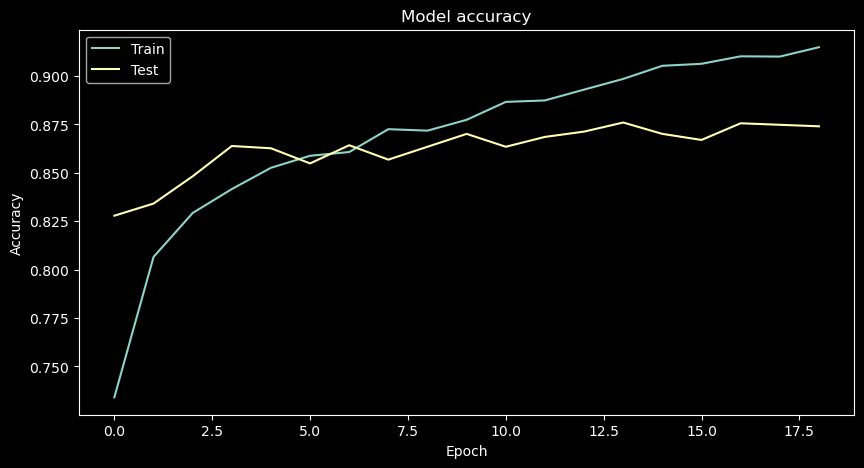

In [99]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

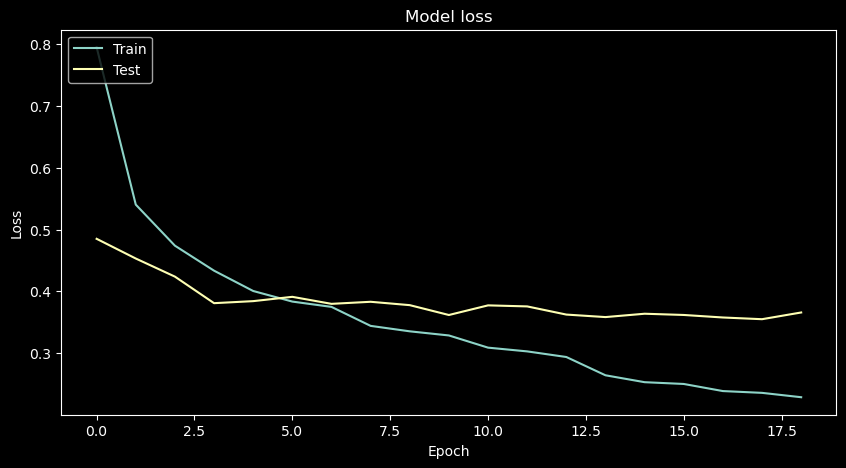

In [100]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [101]:
predicts = np.argmax(model.predict(x_val_float, batch_size=64), axis=-1)
print('Val Accuracy: ', accuracy_score(y_val, predicts))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Val Accuracy:  0.8759780907668232


# Predict on test

In [102]:
ids = x_test['Id'].values

x_test = x_test.drop(columns=['Id'], errors='ignore')
x_test = scaler.fit_transform(x_test)

In [103]:
y_test = np.argmax(model.predict(x_test, batch_size=64), axis=-1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


In [107]:
# final submission
results = pd.DataFrame({
    'Id': ids,
    'label': y_test
})

results.to_csv('submission_fmnist_kaggle.csv', index=False)

In [108]:
print(results.head())

   Id  label
0   0      0
1   1      1
2   2      2
3   3      2
4   4      3
